## Incremental learning with River

In [322]:
from river import active
from river import datasets
import numpy as np
from river import feature_extraction
from river import linear_model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from river import metrics
import sys
from sklearn.metrics import accuracy_score
sys.path.append('.\\..\\..\\..\\Chapter2-Z24-dataset')
from predict import binarize
import os
from sklearn.neighbors import KNeighborsClassifier

In [276]:
X_train = np.load("C:\\Users\\amroa\\Documents\\thesis\\X_train.npy")
labels_train = np.load("C:\\Users\\amroa\\Documents\\thesis\\labels_train.npy")
X_test = np.load("C:\\Users\\amroa\\Documents\\thesis\\X_test.npy")
labels_test = np.load("C:\\Users\\amroa\\Documents\\thesis\\labels_test.npy")

In [277]:
X_train.shape, \
X_test.shape

((544, 906), (68, 906))

In [278]:
# define hyperparameters and data
features_to_keep = 79
neighbors = 41

y_train = binarize(labels_train)
log_reg = LogisticRegression(C = 12.5) 
y_train = binarize(labels_train)
log_reg.fit(X_train, y_train)
sorted_feature_indices = np.argsort(log_reg.coef_[0])[::-1] # get the indices of the most important features in descending order

In [281]:
# dimensionality reduction (to stabilize KNN and avoid dimensionality curse)
indices = sorted_feature_indices[:features_to_keep]
X_train_top_feats = X_train[:, indices]
X_test_top_f = X_test[:, indices]
y_test = binarize(labels_test)

### Method 1: Entropy-sampling 

In [248]:
from sklearn import datasets as skdatasets  # Import to avoid naming conflicts
from river import active
from river import datasets
from river import linear_model
from river import metrics
import re

def testing_model_entropy_sampling(model, X_test):
    X_test_top_f = X_test[:, indices]
    y_test = binarize(labels_test)

    X_river_test = [
        {f"feature_{i}": value for i, value in enumerate(sample)}
        for sample in X_test_top_f
    ]
    y_river_test = y_test.tolist()  
    metric = metrics.Accuracy()

    # Process each sample in the dataset
    for i in range(len(X_river_test)):
        x = X_river_test[i]
        y_true = y_river_test[i]
        y_pred, _ = model.predict_one(x) 
        metric = metric.update(y_true, y_pred)

    return metric

acc_train_all_exp = []
acc_test_all_exp = []
n_samples_all_exp = []

# across 50 seeds
for s in range(50):
    accuracies_train = []
    accuracies_test = []
    samples_used = []
    for i in range(0, 1000, 5):
        # Prepare the data in a format compatible with river
        X_river = [
            {f"feature_{i}": value for i, value in enumerate(sample)}
            for sample in X_train_top_feats
        ]
        y_river = y_train.tolist() 

        metric = metrics.Accuracy()
        base_model = linear_model.LogisticRegression()
        model = active.EntropySampler(base_model, discount_factor=i, seed=s)

        n_samples_used = 0

        # Process each sample in the dataset
        for i in range(len(X_river)):
            x = X_river[i]
            y_true = y_river[i]
            y_pred, ask = model.predict_one(x) 
            metric = metric.update(y_true, y_pred)

            if ask:
                n_samples_used += 1
                model = model.learn_one(x, y_true)  # Learn from the true label
                
        if len(samples_used) > 0 and (samples_used[-1] <= n_samples_used):
            continue

        acc_train = float((re.search(r'(\d+\.\d+)', metric.__str__())).group(1))
        accuracies_train.append(acc_train)
        samples_used.append(n_samples_used)
        #print(f"Number of samples used for learning: {n_samples_used}")
        metric = testing_model_entropy_sampling(model)
        acc_test = float((re.search(r'(\d+\.\d+)', metric.__str__())).group(1))
        accuracies_test.append(acc_test)

    acc_test_all_exp.append(accuracies_test[::-1])
    acc_train_all_exp.append(accuracies_train[::-1])
    n_samples_all_exp.append(samples_used[::-1])

In [249]:
def find_common_numbers(list_of_arrays):
    common_numbers = set(list_of_arrays[0])
    for arr in list_of_arrays[1:]:
        common_numbers &= set(arr)
    return list(common_numbers)

find_common_numbers(n_samples_all_exp) # this is why need interpolation

[544]

In [262]:
def interp_with_extrapolation(x, xp, fp): # interp uses constant extrapolation, this uses slope-based
    y = np.interp(x, xp, fp)
    return y

In [263]:
interpolation_range_samples = np.arange(24, 545, 1)
interp_accs_train = []
interp_accs_test = []
for i in range(len(n_samples_all_exp)):
    exp_i_samples = n_samples_all_exp[i]
    exp_i_acc_train = acc_train_all_exp[i]
    exp_i_acc_test = acc_test_all_exp[i]
    
    interp_extrap_train_i = interp_with_extrapolation(interpolation_range_samples, exp_i_samples, exp_i_acc_train)
    interp_extrap_test_i = interp_with_extrapolation(interpolation_range_samples, exp_i_samples, exp_i_acc_test)
    
    interp_accs_test.append(interp_extrap_test_i)
    interp_accs_train.append(interp_extrap_train_i)

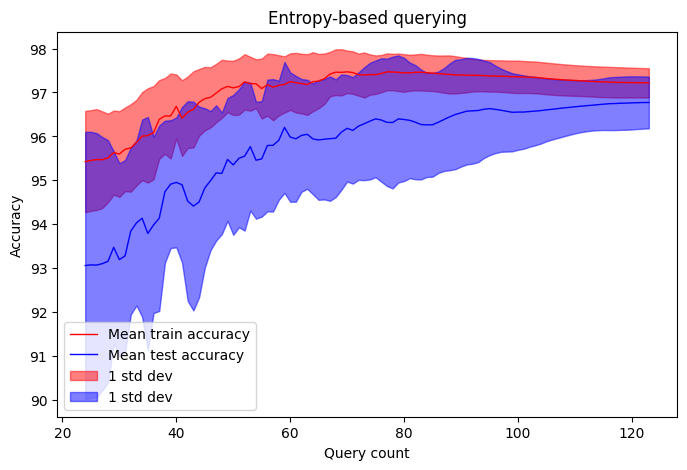

In [271]:
# the fill between plot
import matplotlib.pyplot as plt
y_train_mean = np.mean(interp_accs_train, axis=0)
y_test_mean  = np.mean(interp_accs_test, axis = 0)
train_std = np.std(interp_accs_train, axis=0)
test_std = np.std(interp_accs_test, axis=0)

# increase width of plot
plt.figure(figsize=(8, 5))
end = 100
x = ((interpolation_range_samples)[0:end])
plt.plot(x, y_train_mean[0:end], '-r', label='Mean train accuracy')
plt.plot(x, y_test_mean[0:end], '-b', label='Mean test accuracy')

plt.fill_between(x, (y_train_mean - train_std)[0:end], (y_train_mean + train_std)[0:end], color='red', alpha=0.5, label='1 std dev')
plt.fill_between(x, (y_test_mean - test_std)[0:end], (y_test_mean + test_std)[0:end], color='blue', alpha=0.5, label='1 std dev')
plt.title("Entropy-based querying")
plt.xlabel("Query count")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

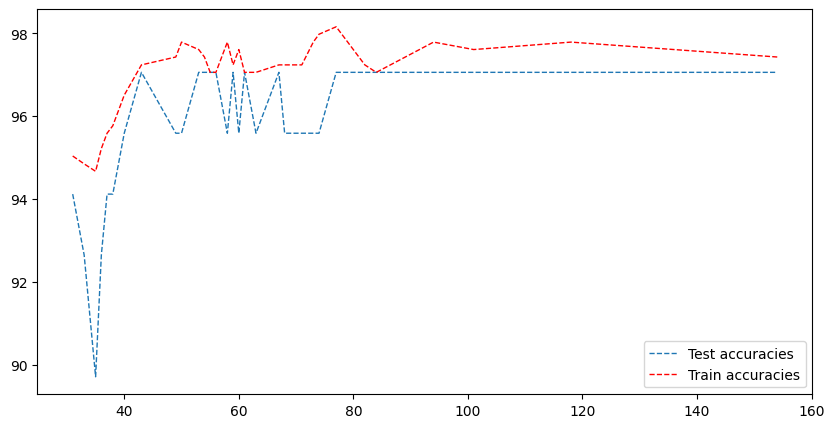

In [169]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

def moving_average_np(data, window_size=5):
    """
    Compute moving average using numpy.
    """
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

rev_test = np.array(accuracies_test)[::-1]
rev_train = np.array(accuracies_train)[::-1]
samples_used_rev = np.array(samples_used)[::-1]

mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.linestyle'] = '--'
plt.figure(figsize=(10, 5)) 
end = 31

"""
smooth_rev_test = moving_average_np(rev_test, window_size=3)
smooth_rev_train = moving_average_np(rev_train, window_size=3)
adjusted_samples = samples_used_rev[0:end]  # Adjusting for window_size=5
"""

plt.plot(samples_used_rev[0:end], rev_test[0:end], label = 'Test accuracies')
plt.plot(samples_used_rev[0:end], rev_train[0:end], color='red', label='Train accuracies')
plt.legend()
plt.show()

### Method 2: Changepoint detection using Gaussian scoring

In [643]:
import random
from river import anomaly
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def gaussian_scorer_multi(y_values, window_size = 25, grace_period = 10, method = 0, plot = True):
    """
    Method: 0 if min of Gaussian anomaly scores for each variable, 1 if max of Gaussian anomaly scores, and 2 if product of scores, 3 if median of scores
    """
    from functools import reduce
    num_vals = y_values.shape[1]
    rng = random.Random(42)
    detectors = [anomaly.GaussianScorer(window_size=window_size, grace_period=grace_period) for el in range(num_vals)]
    anomaly_scores = [[0] for el in range(num_vals)]

    for idx, detector in enumerate(detectors):
        for obs_idx, y in enumerate(y_values[:-1, idx]):
            detector = detector.learn_one(None, y) 
            anomaly_scores[idx].append(detector.score_one(None, y_values[obs_idx+1, idx]))

    anomaly_scores_np = [np.array(el) for el in anomaly_scores]
    result = np.minimum.reduce(anomaly_scores_np) if method == 0 else \
         np.maximum.reduce(anomaly_scores_np) if method == 1 else reduce(np.multiply, anomaly_scores_np) if method == 2 else np.median(np.vstack(anomaly_scores_np), axis=0)
    mnmx = StandardScaler()
    obs = np.arange(len(result))
    normalized_result = mnmx.fit_transform(result.reshape(-1, 1)).flatten()
    if plot:
        import matplotlib.pyplot as plt
        sns.reset_defaults()
        sns.reset_orig()
        plt.figure(figsize=(15, 6))
        nbr_epochs = 544
        for i in range(0, nbr_epochs+1, 32):
            plt.axvline(x=i, color='red', linestyle='--', linewidth=0.8)
        plt.bar(obs, normalized_result)
        plt.ylim(0, 1.15*max(normalized_result))
        string_method = "min_i" if method == 0 else "max_i" if method == 1 else "\prod_i" if method == 2 else "med_i"
        plt.xlabel('Observation (16,384 samples or 2.7 min per observation)')
        plt.ylabel('(Standardized) Gaussian anomaly score')
        plt.title(rf'Anomaly score: $score = 2\ {string_method} \|CDF(x_i) - 0.5\|$')
        text_pos = [i+16 for i in range(0, 544, 32)]
        for idx, pos in enumerate(text_pos):
            plt.text(pos, max(normalized_result)*1.1, f'DS {idx+1}', ha='center', color='red')

        plt.show()
    return result, normalized_result

In [798]:
def plot_distribution(data, title, window = None, threshold = None, damage_zone = None):    
    sns.set_style('whitegrid')
    plt.figure(figsize=(10, 6))
    
    if window is not None:
        data = data[np.logical_and(data >= window[0], data <= window[1])]
    
    if threshold is not None and damage_zone is None:
        below_threshold = data[data < threshold]
        above_threshold = data[data >= threshold]
        sns.histplot(below_threshold, bins='auto', color='#86bf91', edgecolor='black', label='Below Threshold')
        sns.histplot(above_threshold, bins='auto', color='cyan', edgecolor='black', label='Above Threshold')
        plt.legend()
    elif threshold is not None and damage_zone is not None:
        below_threshold = data[data < threshold]
        above_threshold_idx = np.where(data >= threshold)[0]
        print(above_threshold_idx)
        above_threshold_damage = [data[idx] for idx in above_threshold_idx if damage_zone(idx)]
        above_threshold_nodam = [data[idx] for idx in above_threshold_idx if not damage_zone(idx)]
        sns.histplot(below_threshold, bins='auto', color='#86bf91', edgecolor='black', label='Below Threshold')
        sns.histplot(above_threshold_nodam, bins='auto', color='cyan', edgecolor='black', label='Above Threshold (Undamaged)')
        sns.histplot(above_threshold_damage, bins='auto', alpha = 0.6, color='red', edgecolor='black', label='Above Threshold (Damaged)')
        plt.legend()
    else:
        sns.histplot(data, bins='auto', color='#86bf91', edgecolor='black')
    
    plt.title(title, fontsize=18, pad=20)
    plt.xlabel('Standardized anomaly score', fontsize=14, labelpad=15)
    plt.ylabel('Frequency', fontsize=14, labelpad=15)
    plt.tight_layout()
    plt.show()
    
    sns.reset_defaults()
    sns.reset_orig()

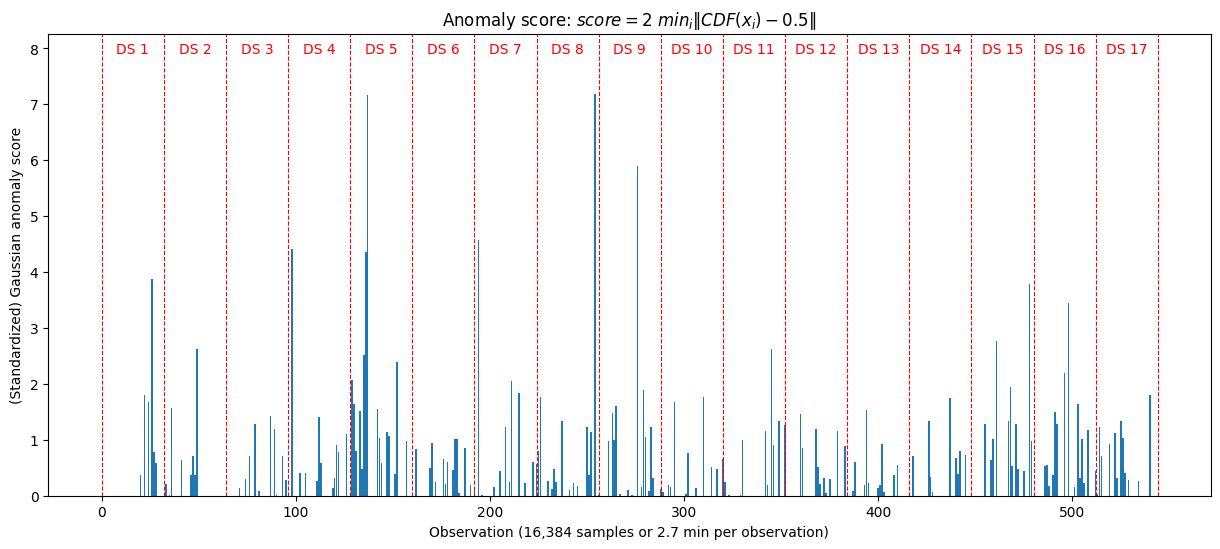

array([137, 254], dtype=int64)

In [663]:
result, n_res = gaussian_scorer_multi(X_train_top_feats, window_size = 45, grace_period = 20)
np.where(n_res > 6)[0]

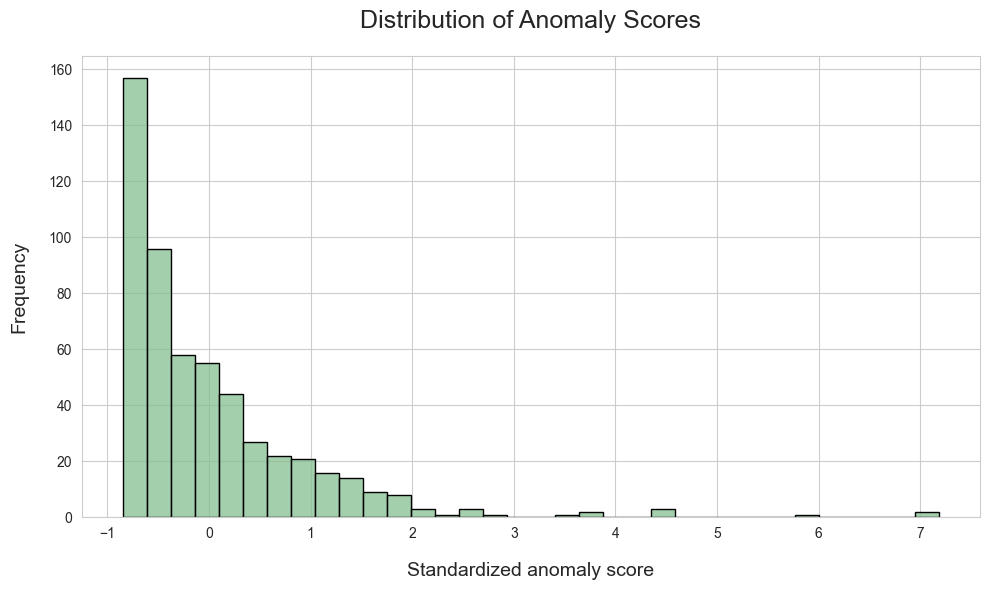

In [664]:
plot_distribution(n_res, 'Distribution of Anomaly Scores')

In [632]:
np.where(y_train == 1)[0][0:20], \
np.argmax(result)

(array([256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
        269, 270, 271, 272, 273, 274, 275], dtype=int64),
 254)

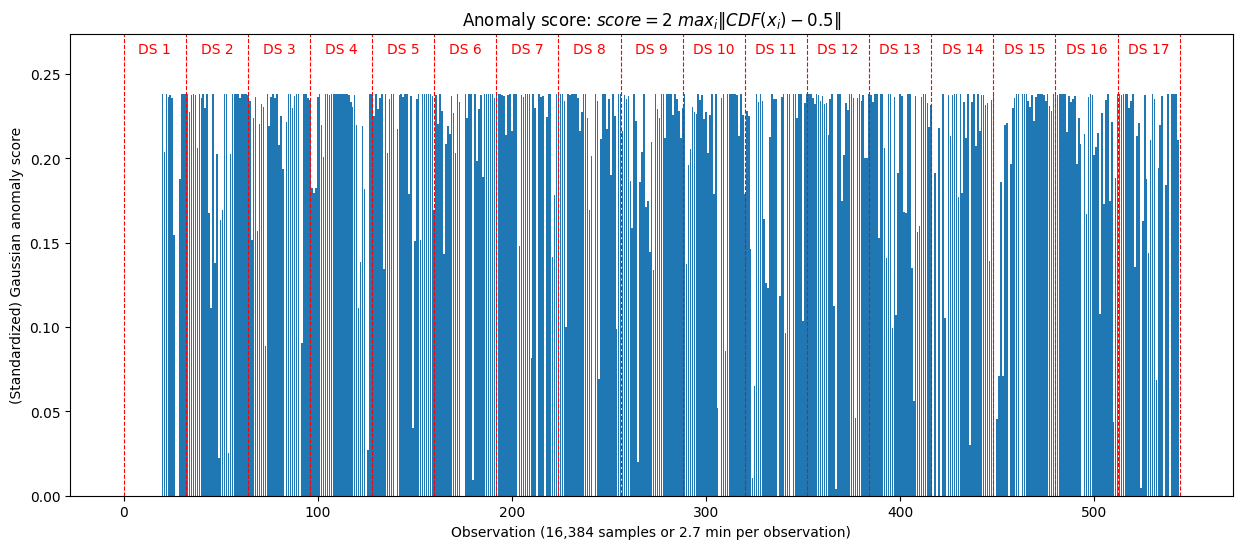

In [665]:
result, n_res = gaussian_scorer_multi(X_train_top_feats, window_size = 45, grace_period = 20, method = 1) # max this time. REMARK: graph is very noisy. Taking a max is not a great idea

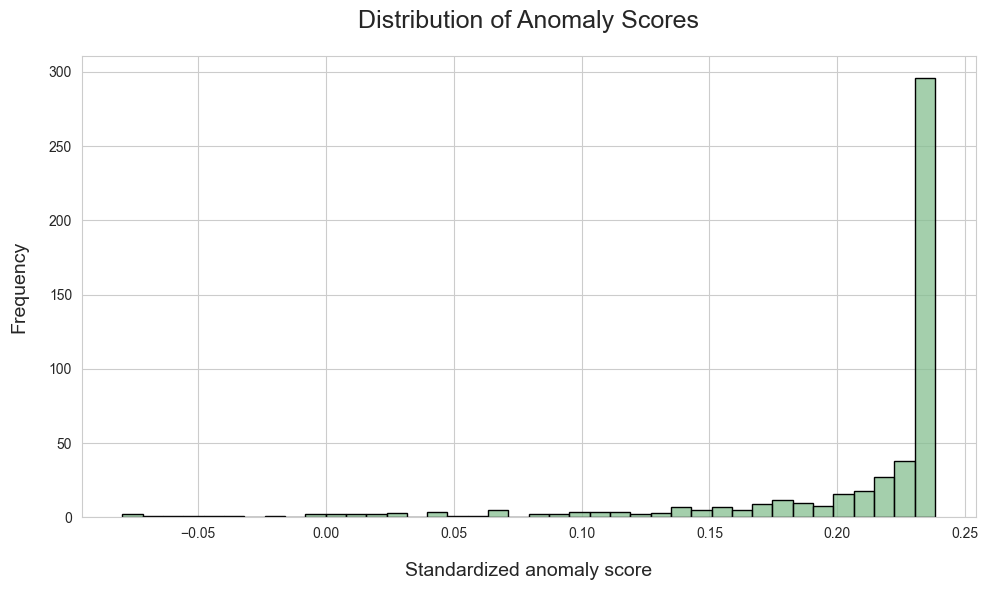

In [666]:
plot_distribution(n_res, 'Distribution of Anomaly Scores', window  = [-0.1, 1])

In [542]:
np.where(y_train == 1)[0][0:20], \
np.argmax(result)

(array([256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
        269, 270, 271, 272, 273, 274, 275], dtype=int64),
 36)

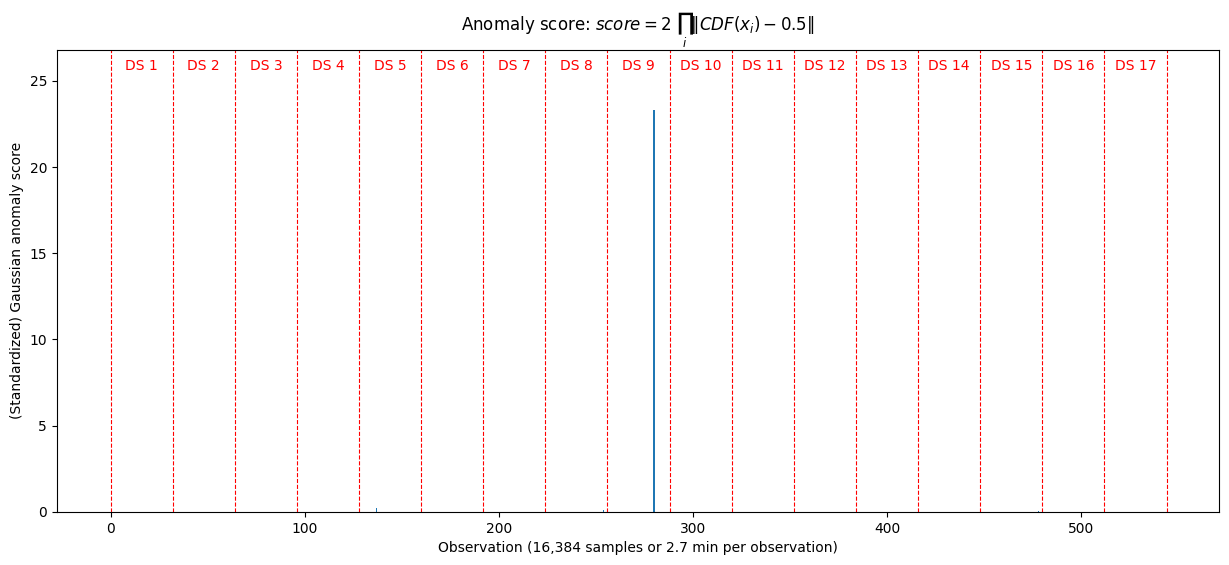

In [659]:
result, n_res = gaussian_scorer_multi(X_train_top_feats, window_size =45, grace_period = 20, method = 2) # product this time

In [660]:
np.where(y_train == 1)[0][0:20], \
np.max(result), np.argmax(result)

(array([256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
        269, 270, 271, 272, 273, 274, 275], dtype=int64),
 2.1481348189988868e-16,
 280)

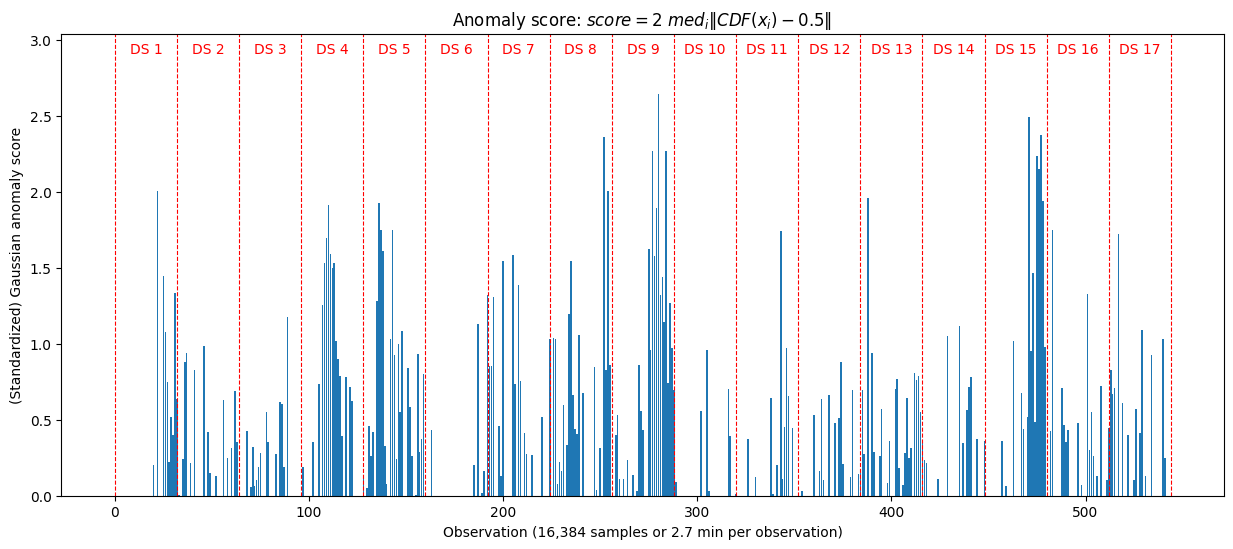

In [667]:
result, n_res = gaussian_scorer_multi(X_train_top_feats, window_size = 45, grace_period = 20, method = 3) # median this time

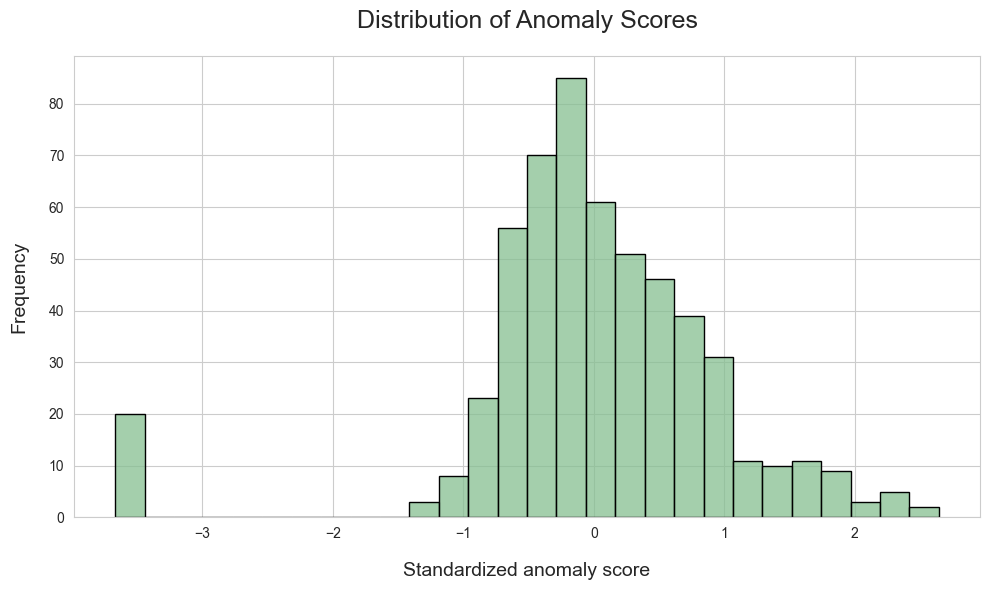

In [669]:
plot_distribution(n_res, 'Distribution of Anomaly Scores')

In [550]:
np.where(y_train == 1)[0][0:20], \
np.max(result), np.argmax(result)

(array([256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
        269, 270, 271, 272, 273, 274, 275], dtype=int64),
 0.8087748785796025,
 280)

In [829]:
# turn these methods into AL algorithms
class AL:
    def __init__(self, anomaly_scores, threshold, labels_after_chgpt, warm_start = False):
        self.threshold = threshold
        self.anomaly_scores = anomaly_scores
        self.labels_after_chgpt = labels_after_chgpt # how many samples to query after changepoint
        self.warm_start = warm_start
    def query(self):
        self.sample_points = np.where(self.anomaly_scores >= self.threshold)[0]
        return self.sample_points # these are only start points of sampling
    def get_label_points(self): # indices of samples to label
        self.query()
        querying_points = []
        [[querying_points.append(num+i) for i in range(self.labels_after_chgpt)] for num in self.sample_points]
        # warm start, comment the next line to avoid warm start
        if self.warm_start:
            querying_points = querying_points + list(range(10))
        res = list(set(querying_points))
        res.sort()
        return res

In [834]:
def ad_to_al(normalized_res, warm_st):
    samples_used = []
    test_accuracies = []
    train_accuracies = []
    print(max(normalized_res))
    mx = max(normalized_res)
    mn = min(normalized_res)

    for i in np.linspace(mn, mx, 14):
        for j in range(1, 11):
            al_min = AL(normalized_res, threshold=i, labels_after_chgpt=j, warm_start=warm_st)
            indices_to_query = al_min.get_label_points()
            indices_to_query = [i for i in indices_to_query if i < X_train.shape[0]]
            samples_used.append(len(indices_to_query))
            train_data = X_train_top_feats[indices_to_query, :]
            train_labels = y_train[indices_to_query]

            if np.unique(train_labels).size == 1:
                print("The training data contains only one unique number") 
                test_accuracies.append(0.5) 
                train_accuracies.append(0.5)
                continue

            log_reg = LogisticRegression(C=0.5) 
            log_reg.fit(train_data, train_labels)
            y_pred = log_reg.predict(X_test_top_f)
            accuracy = accuracy_score(y_test, y_pred)
            test_accuracies.append(accuracy)

            # predict training subset and compute accuracy
            y_train_pred = log_reg.predict(train_data)
            train_accuracy = accuracy_score(train_labels, y_train_pred)
            train_accuracies.append(train_accuracy)
            #print(f"Threshold={i}, Labels After Chgpt={j}: Accuracy={accuracy}%")
    return test_accuracies, train_accuracies, samples_used

In [841]:
# AL
accuracies_train_all_exp = [] # second element for med gaussian sampling
accuracies_test_all_exp = [] # first element for min gaussian sampling
n_samples_all_exp = []
for met_iter in [0, 3, 2]:
    method = met_iter
    _, normalized_res = gaussian_scorer_multi(X_train_top_feats, window_size = 45,  grace_period = 20, method=met_iter, plot=False) # min aggregation
    print(len(normalized_res))
    test_accuracies, train_accuracies, samples_used = ad_to_al(normalized_res, warm_st=False)
    accuracies_test_all_exp.append(test_accuracies)
    accuracies_train_all_exp.append(train_accuracies)
    n_samples_all_exp.append(samples_used)

544
7.185322053693818
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
544
2.6440509698971333
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
544
23.30047979362887
The training data contains only one unique number
The training data contains only one unique number
The training data contains only o

In [842]:
def plot_contour_al(accuracies_train_min, accuracies_test_min, n_samples_min):
    acc_train_matrix = np.array(accuracies_train_min).reshape(14, 10)
    acc_test_matrix = np.array(accuracies_test_min).reshape(14, 10)
    samples_matrix = np.array(n_samples_min).reshape(14, 10)
    print(np.max(np.max(acc_test_matrix, axis = 0)))

    labels_after = np.arange(1, 11)
    threshold = np.arange(int(len(accuracies_test_min)/len(labels_after)))
    X, Y = np.meshgrid(labels_after, threshold)

    fig, axs = plt.subplots(2, 2, figsize=(15, 13.5))  # 2 row, 2 columns

    # Plot for samples_matrix
    cp1 = axs[0][0].contourf(X, Y, samples_matrix, cmap='viridis')
    fig.colorbar(cp1, ax=axs[0][0], label='Query count')
    axs[0][0].set_xlabel("Label run-length")
    axs[0][0].set_ylabel("Anomaly threshold")
    axs[0][0].set_title("Effect of label run-length and threshold on query count", y=1.05)

    # Plot for acc_test_matrix
    cp2 = axs[0][1].contourf(X, Y, acc_test_matrix, levels = 20, cmap='viridis')
    fig.colorbar(cp2, ax=axs[0][1], label='Test Accuracy')
    axs[0][1].set_xlabel("Label run-length")
    axs[0][1].set_ylabel("Anomaly threshold")
    axs[0][1].set_title("Effect of label run-length and threshold on accuracy", y=1.05)

    # Plot for acc_train_matrix
    cp3 = axs[1][0].contourf(X, Y, acc_train_matrix, levels = 20, cmap='viridis')
    fig.colorbar(cp3, ax=axs[1][0], label='Train accuracy')
    axs[1][0].set_xlabel("Label run-length")
    axs[1][0].set_ylabel("Anomaly threshold")
    axs[1][0].set_title("Effect of label run-length and threshold on accuracy", y=1.05)

    # If you have another plot, you can add it with axs[1][1]. Otherwise, you can turn it off:
    axs[1][1].axis('off')

    plt.tight_layout()
    plt.show()

    return acc_train_matrix, acc_test_matrix, samples_matrix

0.9705882352941176


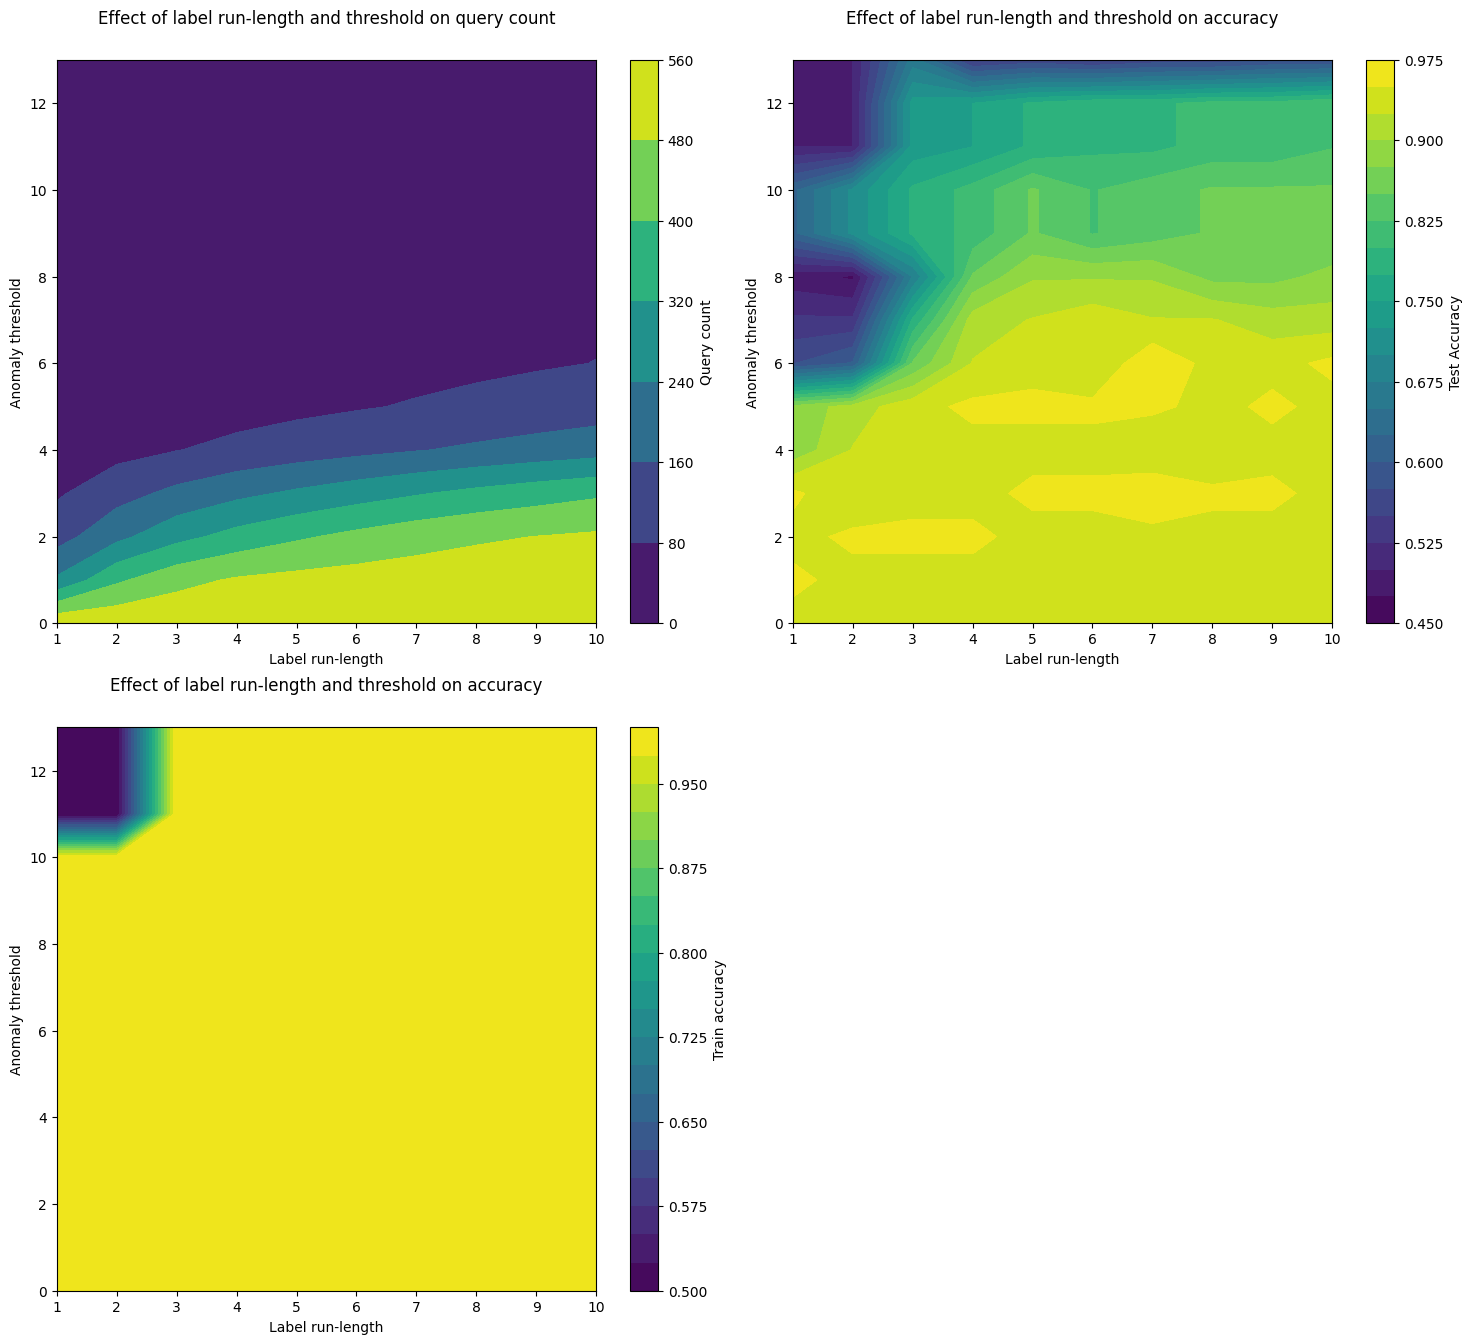

In [843]:
# we consider the min here first 
accuracies_train_min = accuracies_train_all_exp[0] # second element for med gaussian sampling
accuracies_test_min = accuracies_test_all_exp[0] # first element for min gaussian sampling
n_samples_min = n_samples_all_exp[0]

acc_train_matrix, acc_test_matrix, samples_matrix = plot_contour_al(accuracies_train_min, accuracies_test_min, n_samples_min)

In [672]:
# let's examine the interesting region at anomaly threshold 5 
acc_train_matrix

array([[1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [0.5, 0.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [0.5, 0.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [0.5, 0.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ]])

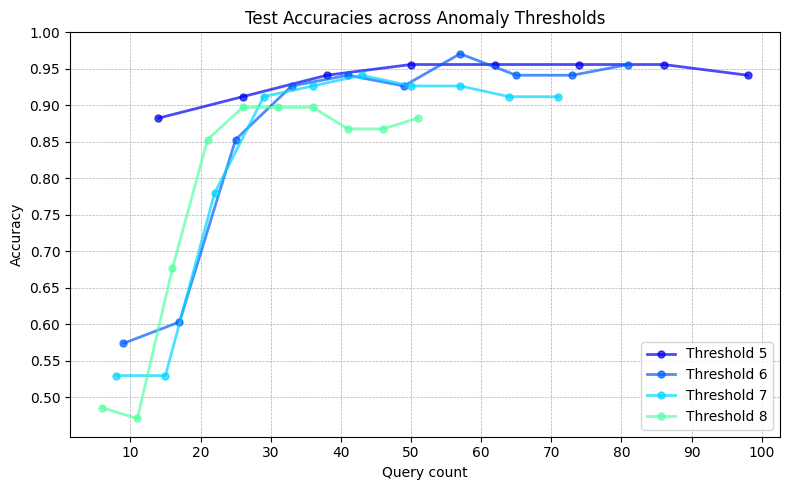

In [820]:
test_accuracies_thresh_5 = acc_test_matrix[5, :]
test_accuracies_thresh_8 = acc_test_matrix[8, :]
test_accuracies_thresh_6 = acc_test_matrix[6, :]
test_accuracies_thresh_7 = acc_test_matrix[7, :]

n_samples_5 = samples_matrix[5, :]
n_samples_6 = samples_matrix[6, :]
n_samples_7 = samples_matrix[7, :]
n_samples_8 = samples_matrix[8, :]

test_accuracies_thresh_5 = test_accuracies_thresh_5[n_samples_5 < 100]
test_accuracies_thresh_6 = test_accuracies_thresh_6[n_samples_6 < 100]
test_accuracies_thresh_7 = test_accuracies_thresh_7[n_samples_7 < 100]
test_accuracies_thresh_8 = test_accuracies_thresh_8[n_samples_8 < 100]

n_samples_8 = n_samples_8[n_samples_8 < 100]
n_samples_7 = n_samples_7[n_samples_7 < 100]
n_samples_6 = n_samples_6[n_samples_6 < 100]
n_samples_5 = n_samples_5[n_samples_5 < 100]

# make the colors close together
colors = plt.cm.jet(np.linspace(0.10, 0.45, 4))
plt.figure(figsize=(8, 5))

alpha = 0.7
# add markers 
plt.plot(n_samples_5, test_accuracies_thresh_5, color=colors[0], alpha = alpha, label='Threshold 5', 
         linewidth=2, linestyle='-', marker='o', markersize=5)
plt.plot(n_samples_6, test_accuracies_thresh_6, color=colors[1], alpha = alpha, label='Threshold 6', 
         linewidth=2, linestyle='-', marker='o', markersize=5)
plt.plot(n_samples_7, test_accuracies_thresh_7, color=colors[2], alpha = alpha, label='Threshold 7', 
         linewidth=2, linestyle='-', marker='o', markersize=5)
plt.plot(n_samples_8, test_accuracies_thresh_8, color=colors[3], alpha = alpha, label='Threshold 8', 
         linewidth=2, linestyle='-', marker='o', markersize=5)

plt.title('Test Accuracies across Anomaly Thresholds')
plt.xlabel('Query count')
plt.ylabel('Accuracy')

plt.grid(True, which='major', linestyle='--', linewidth=0.5)
num_ticks = 10  # or however many you want
x_ticks = np.linspace(10, 100, num_ticks)
plt.xticks(x_ticks)
plt.yticks(np.linspace(0.5, 1, 11))
plt.legend()
plt.tight_layout()
plt.show()

2.858876396386216
Above the threshold lies 0.016544117647058824 of the data and below it 0.9834558823529411 of the data
[ 26  98 136 137 194 254 276 478 498]


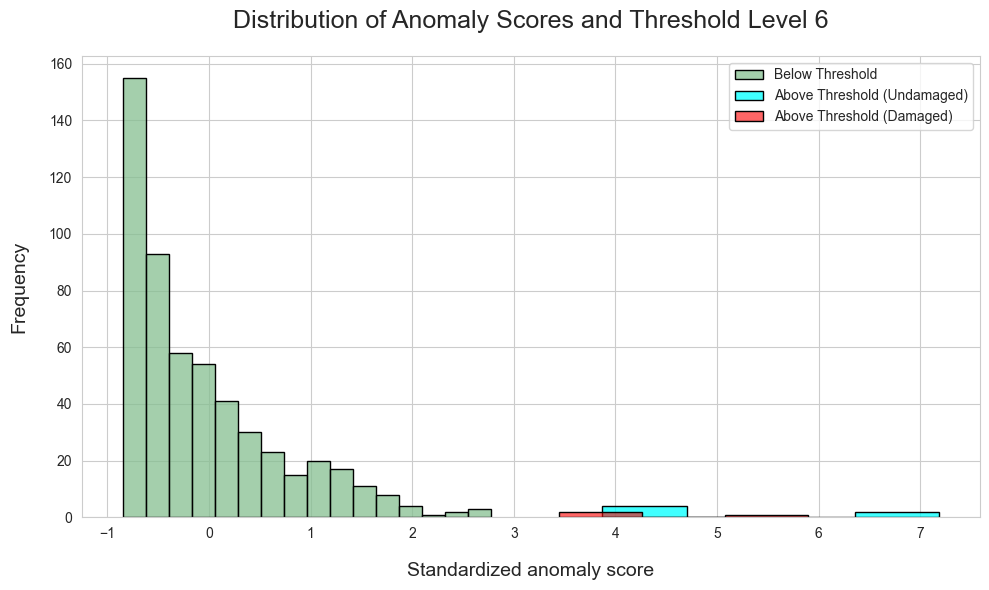

In [821]:
# okay, so it seems threshold 6 performs best let's visualize it
_, normalized_res = gaussian_scorer_multi(X_train_top_feats, window_size = 45,  grace_period = 20, method=0, plot=False) # min aggregation
threshold_6 = np.linspace(min(normalized_res), max(normalized_res), 14)[6] 
print(threshold_6)
print(f"Above the threshold lies {np.sum(normalized_res > threshold_6)/len(normalized_res)} of the data and below it {1- np.sum(normalized_res > threshold_6)/len(normalized_res)}"  
      f" of the data")
plot_distribution(normalized_res, "Distribution of Anomaly Scores and Threshold Level 6", threshold=threshold_6, damage_zone=lambda x: x >= 256)

### Method 3: ARIMA

In [49]:
import pandas as pd
import numpy as np
import arimafd as oa
import sys
from io import StringIO
sys.path.append('.\\..\\..\\..\\Chapter2-Z24-dataset')
from preprocess import get_avt_files, get_dataframes, preprocess_without_std

In [50]:
# get the acceleration signals
avt_files = get_avt_files("C:\\Users\\amroa\\Documents\\thesis\\data")
dfs_acc = get_dataframes(avt_files)
dfs_acc = pd.concat(dfs_acc, axis=0)
dfs_acc.reset_index(drop=True, inplace=True)
dfs_acc = dfs_acc.apply(lambda x: preprocess_without_std(x), axis=0) 
dfs_acc.shape

(10027008, 5)

In [ ]:
batch_size = 16384 # try with half of this also
nbr_samples = dfs_acc.shape[0]
change_points = []
windows = int(nbr_samples/batch_size) #  nbr of windows
anomalies= []

for i in range(windows):
    print(f"--- iter {i} ---")
    arima = oa.Arima_anomaly_detection(ar_order=4)
    window_1 = dfs_acc[i*batch_size:(i+1)*batch_size]
    window_2 = dfs_acc[(i+1)*batch_size:(i+2)*batch_size]
    arima.fit(window_1, window = int(batch_size//2), window_insensitivity = batch_size - 1)
    ts_anomaly = arima.predict(window_2, window = int(batch_size//2), window_insensitivity= batch_size - 1)
    np.save(f"arima_{i}.npy", ts_anomaly.to_numpy())

In [793]:
# extract the relevant file indices for training and testing separately
test_indices=  np.array([])
train_indices=  np.array([])

for i in range(17):
    random.seed(i)
    nbr_splits = 36 #  recall 612/17 = 36, where 612 = total nbr of epochs, 17 is nbr of scenarios
    test_split = 4
    test_indices = np.append(test_indices, i*nbr_splits + np.array(random.sample(range(nbr_splits), test_split)))
    train_indices = np.append(train_indices,  i*nbr_splits+ np.array([x for x in range(nbr_splits) if x not in test_indices]))

print(len(train_indices))

544


In [790]:
def plot_anomalies(title, path):
    # first window always healthy
    perc_ones = [0] # percent of ones in each window
    nbr_epochs = 544
    tot_epochs = 612
    for i in range(tot_epochs):
        if i in train_indices:
            cur_window = np.load(f"{path}/arima_{i}.npy")
            position_ones = np.where(cur_window == 1)[0]
            perc_ones.append(len(position_ones)/batch_size)

    scaler = StandardScaler()
    counts = scaler.fit_transform(np.array(perc_ones).reshape(-1, 1)).flatten()

    plt.figure(figsize=(15, 6)) 
    print(len(counts), np.where(counts > 3.5)[0])
    plt.bar(range(len(counts)), counts)
    plt.xlabel('Epoch (2.7 min ~ 16,384 samples)')
    plt.ylabel('(Standardized) percent of anomalies per epoch')
    plt.ylim(0, 1.10*max(counts))
    plt.title(title)

    for i in range(0, nbr_epochs+1, int(nbr_epochs/17)):
        plt.axvline(x=i, color='red', linestyle='--', linewidth=0.8)

    text_pos = [i+int(nbr_epochs/(2*17)) for i in range(0, nbr_epochs, int(nbr_epochs/17))]
    for idx, pos in enumerate(text_pos):
        plt.text(pos, max(counts)*0.9, f'DS {idx+1}', ha='center', color='red')

    plt.show()

    return counts

483 [ 30  65 149 188 238 244 250]


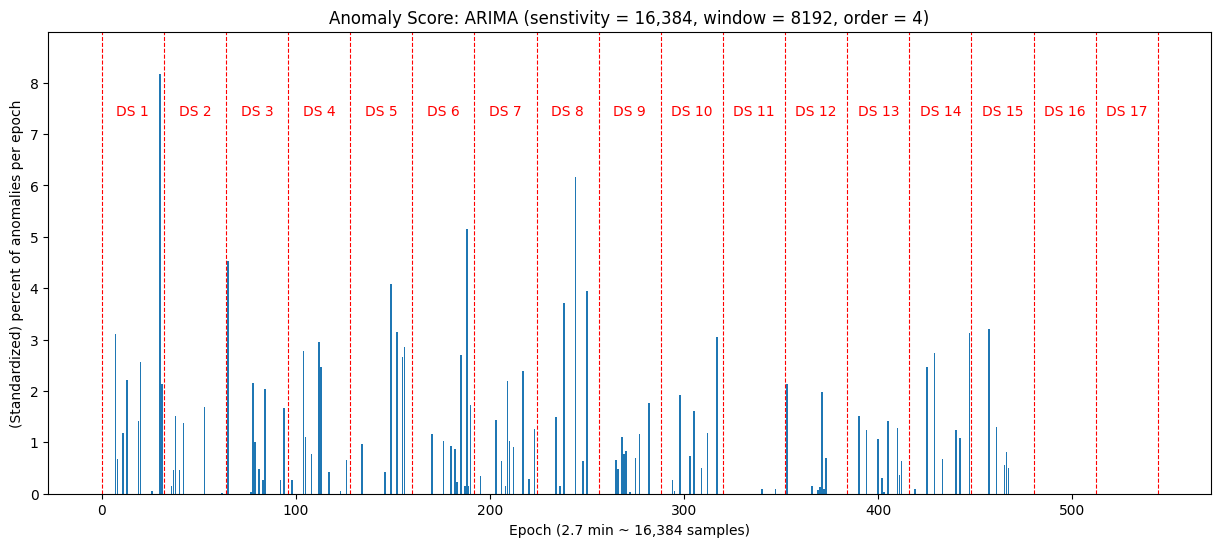

In [791]:
n_res = plot_anomalies("Anomaly Score: ARIMA (senstivity = 16,384, window = 8192, order = 4)", "./arima_16383_sens_8192_win")

483 [ 54 172 202 206 272 422]


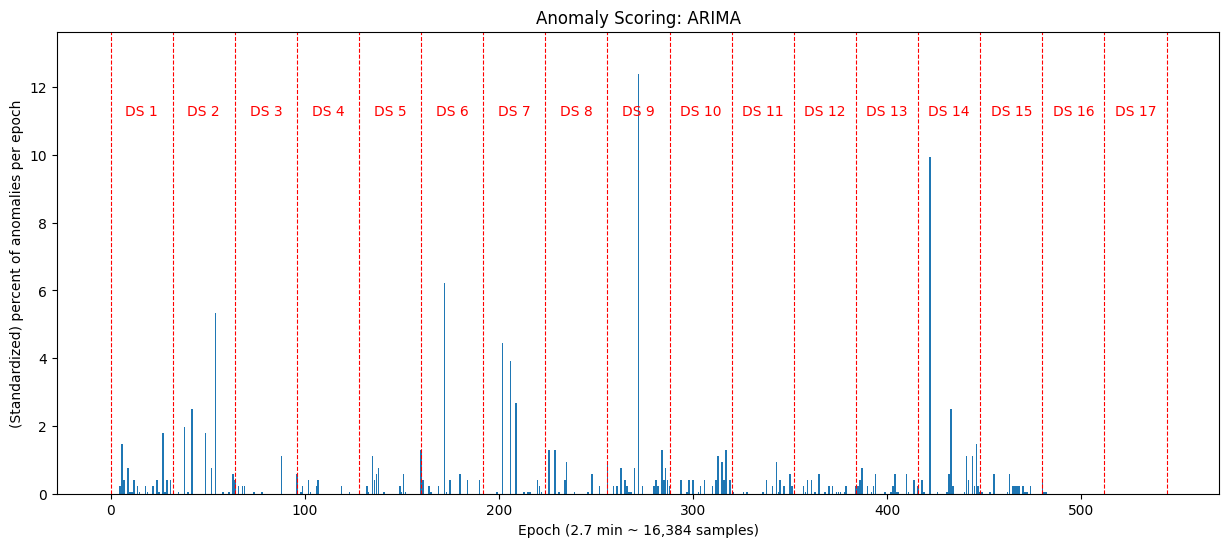

In [822]:
n_res = plot_anomalies("Anomaly Scoring: ARIMA", "./arima_100_sens_100_win") 

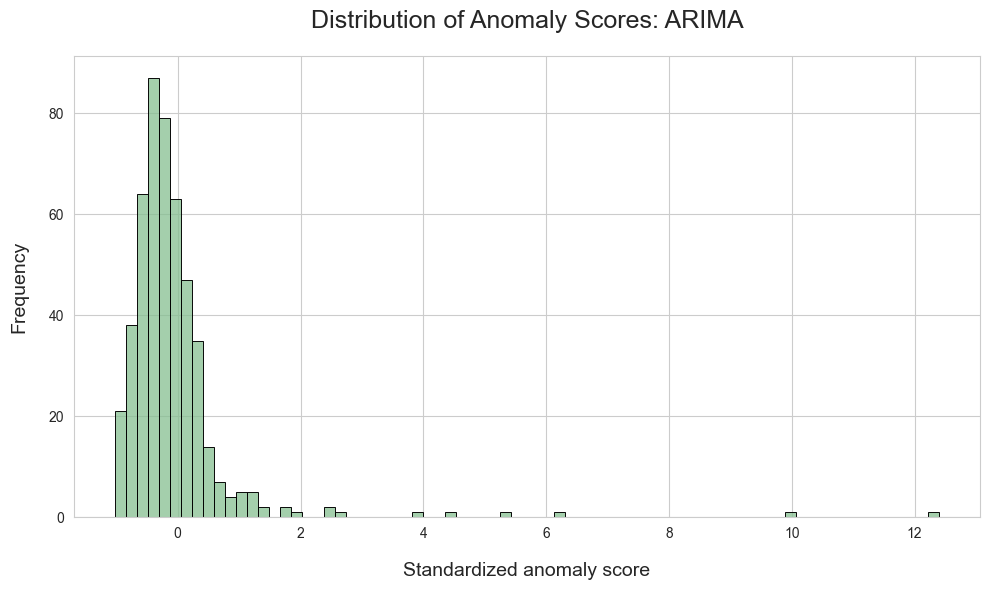

In [823]:
plot_distribution(n_res, "Distribution of Anomaly Scores: ARIMA")

In [854]:
# AL
test_accuracies, train_accuracies, samples_used = ad_to_al(n_res, warm_st=False)

12.395315594044826


0.9705882352941176


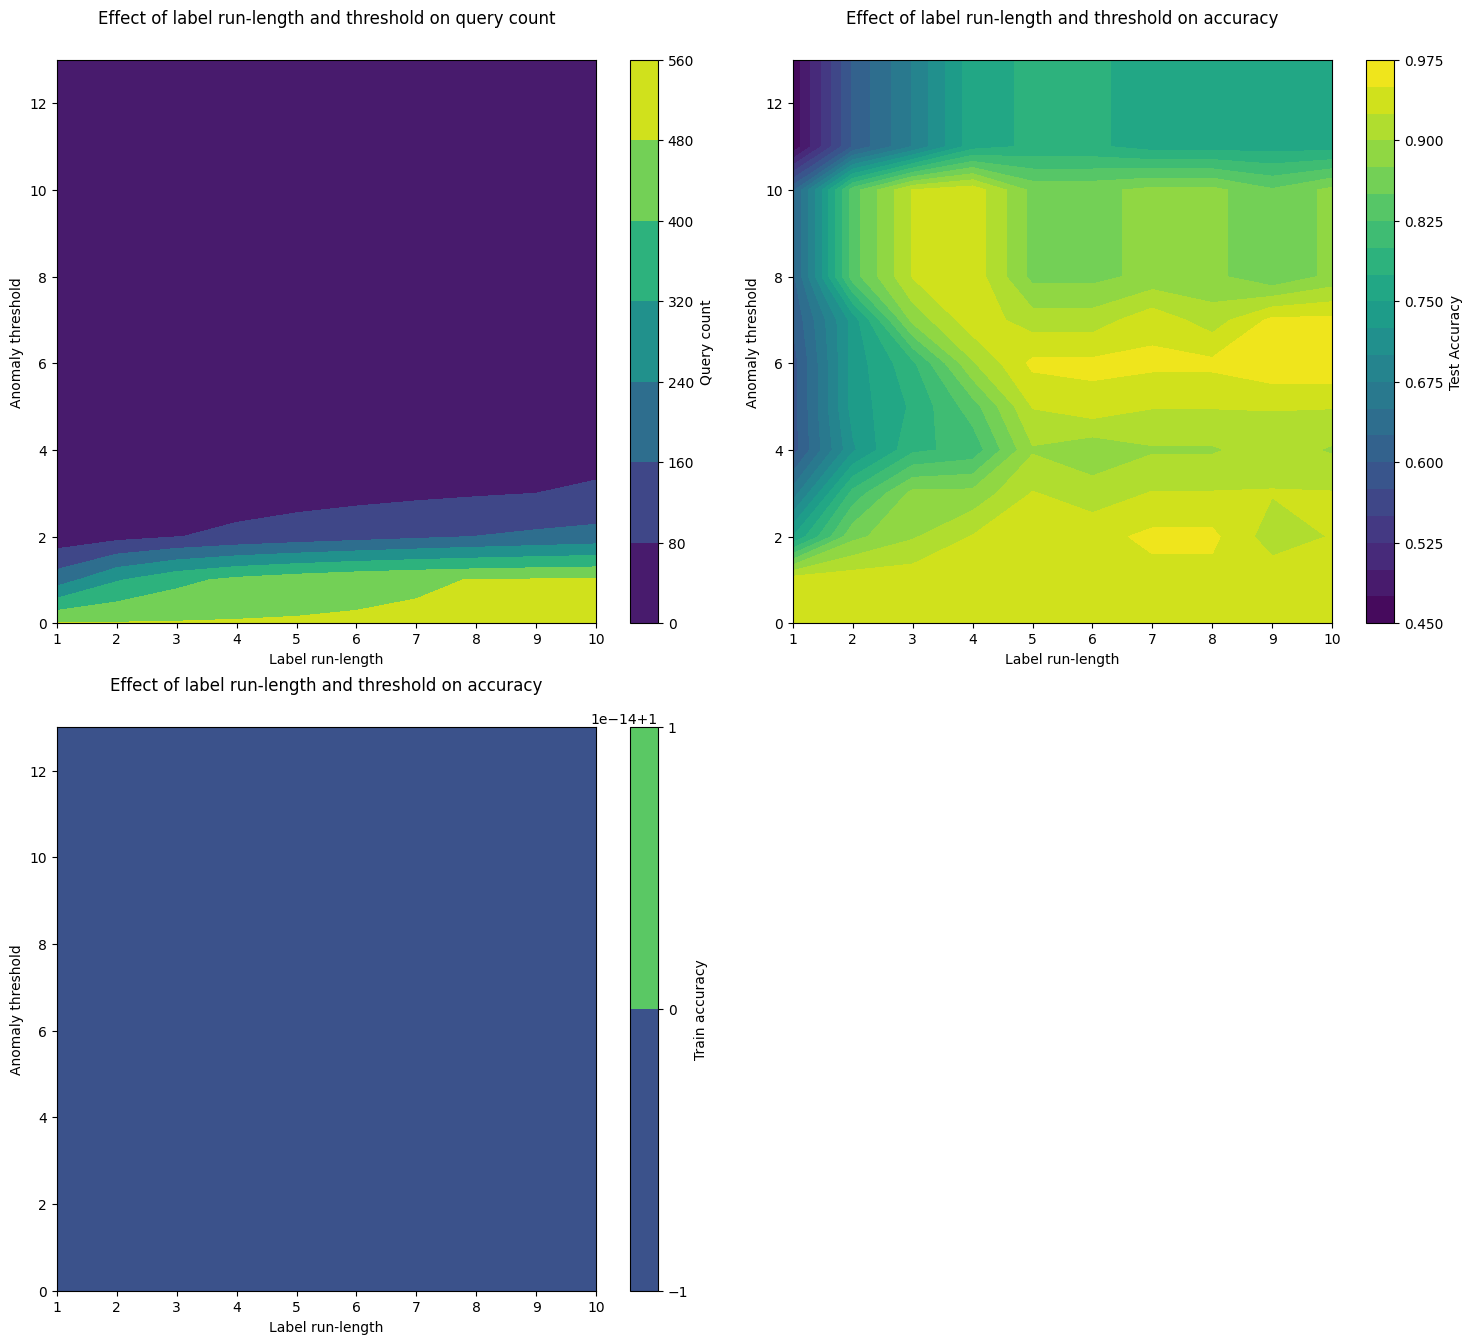

In [855]:
acc_train_matrix, acc_test_matrix, samples_matrix = plot_contour_al(train_accuracies, test_accuracies, samples_used)

In [856]:
acc_test_matrix

array([[0.94117647, 0.94117647, 0.94117647, 0.94117647, 0.94117647,
        0.94117647, 0.94117647, 0.94117647, 0.94117647, 0.94117647],
       [0.94117647, 0.94117647, 0.94117647, 0.94117647, 0.94117647,
        0.94117647, 0.94117647, 0.94117647, 0.94117647, 0.94117647],
       [0.75      , 0.86764706, 0.89705882, 0.92647059, 0.94117647,
        0.94117647, 0.95588235, 0.95588235, 0.91176471, 0.92647059],
       [0.66176471, 0.80882353, 0.88235294, 0.88235294, 0.92647059,
        0.91176471, 0.92647059, 0.92647059, 0.92647059, 0.92647059],
       [0.58823529, 0.72058824, 0.79411765, 0.80882353, 0.89705882,
        0.88235294, 0.89705882, 0.89705882, 0.91176471, 0.89705882],
       [0.58823529, 0.73529412, 0.77941176, 0.83823529, 0.92647059,
        0.94117647, 0.92647059, 0.92647059, 0.92647059, 0.92647059],
       [0.58823529, 0.73529412, 0.79411765, 0.89705882, 0.95588235,
        0.95588235, 0.95588235, 0.95588235, 0.97058824, 0.97058824],
       [0.60294118, 0.73529412, 0.8823529

#### Supplementary: Example usage of RiverML on iris from Sklearn

In [79]:
"""
from sklearn import datasets as skdatasets  # Import to avoid naming conflicts
from river import active
from river import datasets
from river import linear_model
from river import metrics

# Load the iris dataset from sklearn
iris_sk = skdatasets.load_iris()

# Prepare the data in a format compatible with river
X_river = [
    {f"feature_{i}": value for i, value in enumerate(sample)}
    for sample in iris_sk['data']
]
y_river = iris_sk['target'].tolist()  # Converting to list for easier iteration

metric = metrics.Accuracy()
base_model = linear_model.LogisticRegression()
model = active.EntropySampler(base_model, seed=42)

n_samples_used = 0

# Process each sample in the dataset
for i in range(len(X_river)):
    x = X_river[i]
    y_true = y_river[i]
    y_pred, ask = model.predict_one(x)  # x is now a dictionary
    metric = metric.update(y_true, y_pred)

    if ask:
        n_samples_used += 1
        model = model.learn_one(x, y_true)  # Learn from the true label

print(metric)
print(f"Number of samples used for learning: {n_samples_used}")
"""

'\nfrom sklearn import datasets as skdatasets  # Import to avoid naming conflicts\nfrom river import active\nfrom river import datasets\nfrom river import linear_model\nfrom river import metrics\n\n# Load the iris dataset from sklearn\niris_sk = skdatasets.load_iris()\n\n# Prepare the data in a format compatible with river\nX_river = [\n    {f"feature_{i}": value for i, value in enumerate(sample)}\n    for sample in iris_sk[\'data\']\n]\ny_river = iris_sk[\'target\'].tolist()  # Converting to list for easier iteration\n\nmetric = metrics.Accuracy()\nbase_model = linear_model.LogisticRegression()\nmodel = active.EntropySampler(base_model, seed=42)\n\nn_samples_used = 0\n\n# Process each sample in the dataset\nfor i in range(len(X_river)):\n    x = X_river[i]\n    y_true = y_river[i]\n    y_pred, ask = model.predict_one(x)  # x is now a dictionary\n    metric = metric.update(y_true, y_pred)\n\n    if ask:\n        n_samples_used += 1\n        model = model.learn_one(x, y_true)  # Learn f